# Vigiliant Asset Allocation with momentum
#### Representative asset classes including Market Index ETF, sector etf, bond etf
#### Result is driven from 2007 to 2021 market data

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import pandas as pd
import numpy as np

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import momentum_rebalance_strategy

import quantstats

### Load Data of each asset classes
#### Use representative ETF to model strategy. Data should be in yld format
#### [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [17]:
asset_class_ticker =[
    # Offensive Assets
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEI",  # iShares 3-7 Year Treasury Bond ETF                    2007-01-05
    "BND",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    ]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

In [18]:
# for weekly rebalance strategy
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()

# to draw benchmark
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()
windows = 12

In [19]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [20]:
def get_momentum(yld_df):
    """
    calculate momentum of sectors. using 12 month, 6 month, 3 month market price of asset
    input
    yiled_df : dataframe with weekly yield of asset classes

    returns : momentum in pandas dataframe format. momentum of each asset classes for give date
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # data set consists of weekly data, 52 weeks per year = 12 month per year
            if i > windows :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                current = yld_df[asset].iloc[i]
                before_1m = yld_df[asset].iloc[i-1]
                before_3m = yld_df[asset].iloc[i-3]
                before_6m = yld_df[asset].iloc[i-6]
                before_12m = yld_df[asset].iloc[i-12]

                momentum.loc[date, asset] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                            + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
            else:
                momentum.loc[date, asset] = 0
            i = i + 1

    # abnormal data processing
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)

    return momentum

def select_sector(yld_df):
    """
    select top 4 offensive sectors if condition satisfied.
    If failed to satisfy offensive condition, escape to Defensive strategy.

    Criteria: if any of offensive asset classes show negative momentum score, escape to defensive assets.

    returns: selected_tickers in list format. list with top 5 momentum in given period`
    """
    momentum_df = get_momentum(yld_df)

    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4'],
        index=momentum_df.index
    )

    print("S&P500 market signal : Total ",momentum_df.count()[0])
    print("postive signal : ", momentum_df[momentum_df['IVV'] >= 0]['IVV'].count())
    print("negative signal : ", momentum_df[momentum_df['IVV'] < 0]['IVV'].count())


    print("Developed market signal : Total ",momentum_df.count()[0])
    print("postive signal : ", momentum_df[momentum_df['VEA'] >= 0]['VEA'].count())
    print("negative signal : ", momentum_df[momentum_df['VEA'] < 0]['VEA'].count())

    print("Emerging market signal : Total ",momentum_df.count()[0])
    print("postive signal : ", momentum_df[momentum_df['VWO'] >= 0]['VWO'].count())
    print("negative signal : ", momentum_df[momentum_df['VWO'] < 0]['VWO'].count())

    print("Corporate bond market signal : Total ",momentum_df.count()[0])
    print("postive signal : ", momentum_df[momentum_df['LQD'] >= 0]['LQD'].count())
    print("negative signal : ", momentum_df[momentum_df['LQD'] < 0]['LQD'].count())

    for date in momentum_df.index:
        snp_momentum = momentum_df.loc[date,'IVV']
        dev_momentum = momentum_df.loc[date,'VEA']
        eme_momentum = momentum_df.loc[date,'VWO']
        bnd_momentum = momentum_df.loc[date,'LQD']

        short_momentum = momentum_df.loc[date,'SHY']
        mid_momentum = momentum_df.loc[date,'IEI']
        long_momentum = momentum_df.loc[date,'BND']
        tip_momentum = momentum_df.loc[date,'TIP']

        if snp_momentum >= 0 and dev_momentum >= 0 and eme_momentum >= 0 and bnd_momentum >= 0:
            selected_momentum.loc[date,'momentum_1'] = snp_momentum
            selected_ticker.loc[date,'momentum_1'] = 'IVV'

            selected_momentum.loc[date,'momentum_2'] = dev_momentum
            selected_ticker.loc[date,'momentum_2'] = 'VEA'

            selected_momentum.loc[date,'momentum_3'] = eme_momentum
            selected_ticker.loc[date,'momentum_3'] = 'VWO'

            selected_momentum.loc[date,'momentum_4'] = bnd_momentum
            selected_ticker.loc[date,'momentum_4'] = 'LQD'

        else:
            selected_momentum.loc[date,'momentum_1'] = short_momentum
            selected_ticker.loc[date,'momentum_1'] = 'SHY'

            selected_momentum.loc[date,'momentum_2'] = mid_momentum
            selected_ticker.loc[date,'momentum_2'] = 'IEI'

            selected_momentum.loc[date,'momentum_3'] = long_momentum
            selected_ticker.loc[date,'momentum_3'] = 'BND'

            selected_momentum.loc[date,'momentum_4'] = tip_momentum
            selected_ticker.loc[date,'momentum_4'] = 'TIP'

    return selected_ticker


def vaa_momentum(yld_df):
    """
    returns : market portfolio in pandas dataframe format.
    """
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in mom_ticker_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/4
    mp_table = mp_table.fillna(0)
    return mp_table

def trim_data(yld_df, mp_table, benchmark_yield_df):
    """
    since momentum strategy uses 12 month lagged momentum, first 12 month data cannot be used
    return : yld_df, mp_table, bm_yld in dataframe format
    """
    yld_df = yld_df.iloc[windows + 1:]
    mp_table = mp_table.iloc[windows + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[windows + 1:]
    return yld_df, mp_table, benchmark_yield_df

In [21]:
mp_table_result = vaa_momentum(yield_df)
yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)

S&P500 market signal : Total  176
postive signal :  50
negative signal :  126
Developed market signal : Total  176
postive signal :  56
negative signal :  120
Emerging market signal : Total  176
postive signal :  50
negative signal :  126
Corporate bond market signal : Total  176
postive signal :  55
negative signal :  121


In [22]:
# How many times this strategy escaped from risky but opprotunistic assets
print("frequency of portfolio")
mp_table_result.sum() * 2
# escaped quite a lot of times...

frequency of portfolio


IVV     0.5
VEA     0.5
VWO     0.5
LQD     0.5
SHY    81.0
IEI    81.0
BND    81.0
TIP    81.0
dtype: float64

In [23]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=vaa_momentum, yld_df=yield_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy = rebal_strategy.iloc[52:]
rebal_strategy

S&P500 market signal : Total  163
postive signal :  49
negative signal :  114
Developed market signal : Total  163
postive signal :  52
negative signal :  111
Emerging market signal : Total  163
postive signal :  46
negative signal :  117
Corporate bond market signal : Total  163
postive signal :  49
negative signal :  114


,strategy_return,benchmark_return,IVV,VEA,VWO,LQD,SHY,IEI,BND,TIP,SUM
Date,,,,,,,,,,,
2013-01-31,-0.006836,0.010475,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
2013-02-28,-0.00539,0.01544,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
2013-03-31,0.007135,0.014727,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
2013-04-30,0.000165,0.00247,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
2013-05-31,0.006251,-0.015407,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,-0.003839,0.024221,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
2021-12-31,0.004143,0.008085,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0
2022-01-31,-0.005368,0.023965,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,1.0


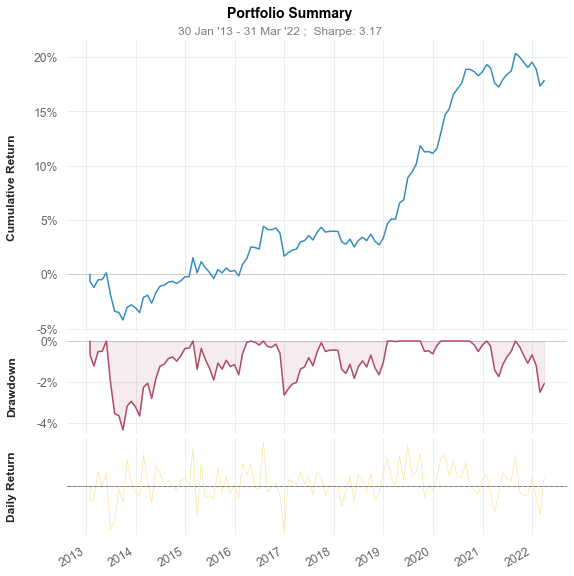

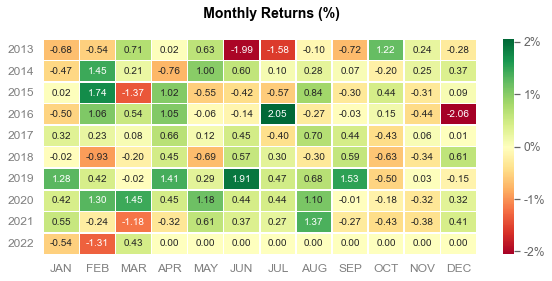

In [24]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

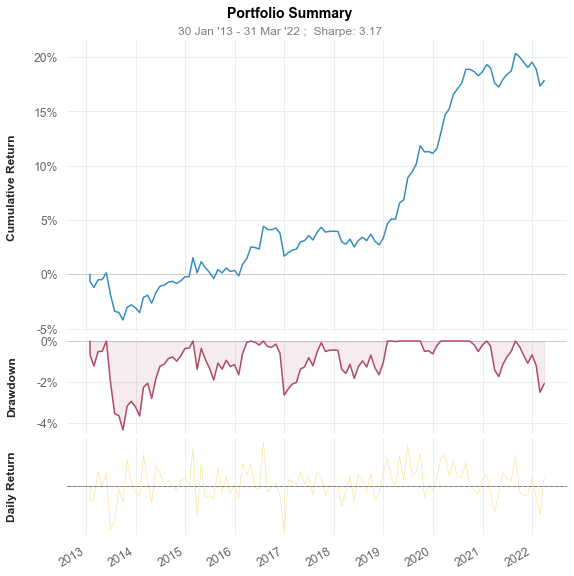

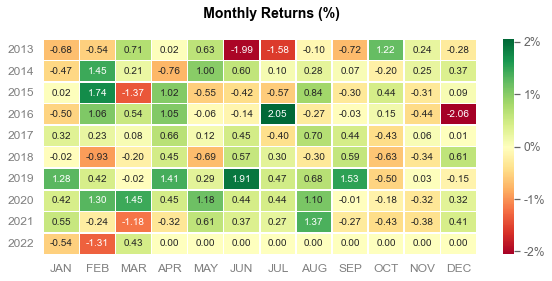

In [25]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-01-31  2013-01-31
End Period                 2022-03-31  2022-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          17.84%      88.37%
CAGR﹪                     1.81%       7.15%

Sharpe                     3.18        5.3
Smart Sharpe               3.1         5.17
Sortino                    5.26        9.23
Smart Sortino              5.13        8.99
Sortino/√2                 3.72        6.52
Smart Sortino/√2           3.62        6.36
Omega                      1.69        1.69

Max Drawdown               -4.33%      -6.86%
Longest DD Days            883         489
Volatility (ann.)          11.94%      27.91%
R^2                        0.0         0.0
Calmar                     0.42        1.04
Skew                       -0.12       -0.28
Kurtosis                   0.71        0.52

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2013-06-30,2013-09-30,2015-02-28,608,-4.334962,-3.659825
2,2016-08-31,2016-12-31,2019-01-31,883,-2.634949,-2.324591
3,2021-09-30,2022-02-28,2022-03-31,182,-2.500202,-2.076704
4,2015-03-31,2015-07-31,2016-04-30,396,-1.897213,-1.647177
5,2021-02-28,2021-04-30,2021-08-31,184,-1.734205,-1.421117


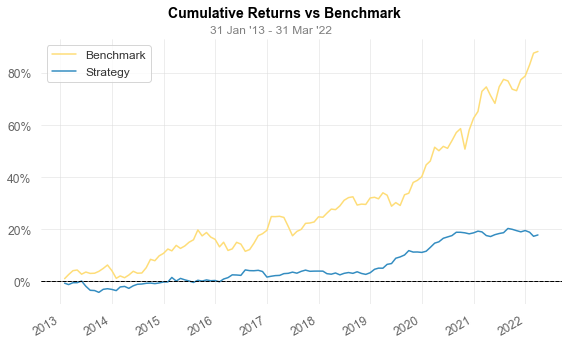

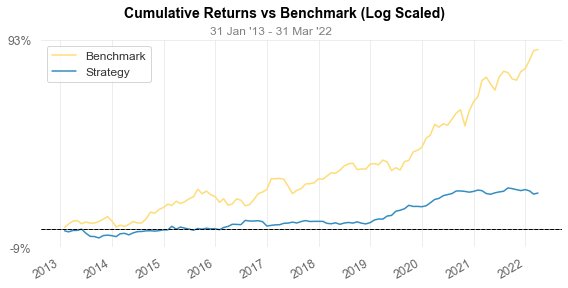

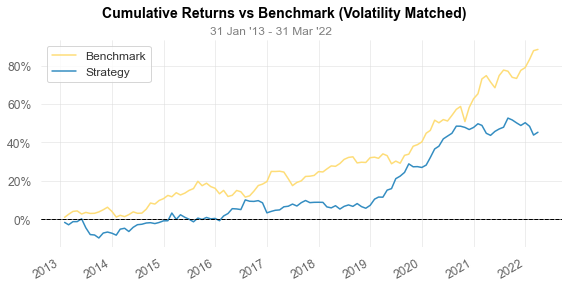

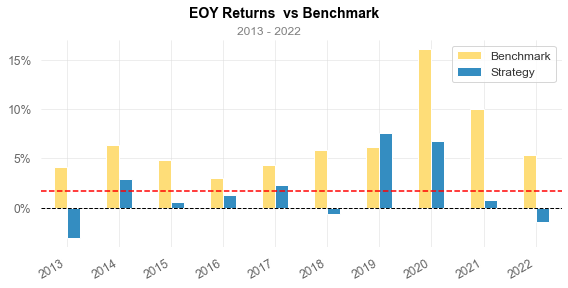

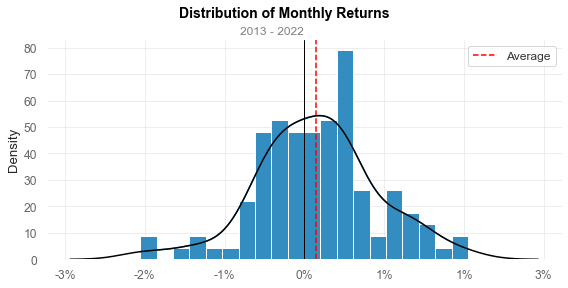

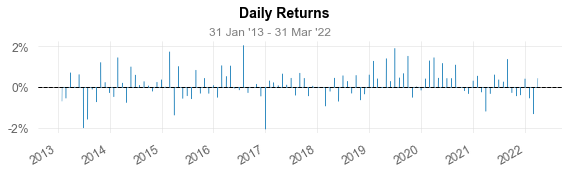

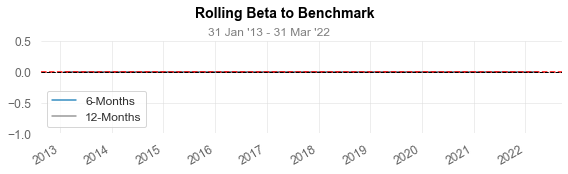

IndexError: index 0 is out of bounds for axis 0 with size 0

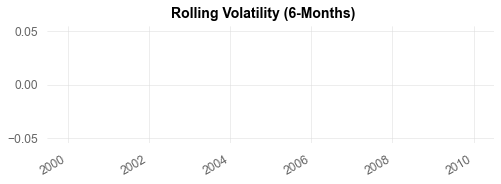

In [26]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)

In [ ]:
canaria = yield_df[['IVV','VEA','VWO','LQD']]
canaria.corr()

In [ ]:
snp_dev_same_direction = len(canaria[canaria['IVV'] * canaria['VEA'] >= 0])
snp_em_same_direction = len(canaria[canaria['IVV'] * canaria['VWO'] >= 0])
snp_bnd_same_direction = len(canaria[canaria['IVV'] * canaria['LQD'] >= 0])
print("same direction rate follows : ")
print("developed market : " ,snp_dev_same_direction/len(canaria))
print("emerging market : " ,snp_em_same_direction/len(canaria))
print("corp bond market : " ,snp_bnd_same_direction/len(canaria))


## Why this strategy always escape from market

|Monthly Signal|S&P500|Developed|Emerging|CorpBond|
|---|---|---|---|---|
|**Postive**|50|56|50|55|
|**Negative**|126|120|126|121|

#### canaria option acts if any canaria condition satisfied.
wrong way pattern of corporate bond market triggered sategy pin too often,
this means that corporate bond market triggered the strategy to escape from market,
meaning that huge opportunity cost from rising developed equity market